# Geospatial Data Visualisation of the London Public Bike Scheme 

Data for 10 million bike journeys taken from over 700 bike stations of the London public bike scheme in the 365-day period for the year of 2017 

The number of daily journeys started at each station is calculated, along with median and total journey duration. As station capacity differs across stations the mean daily journey count per station capacity is plotted for each station. The area within which the scheme operates is divided into regions (voronoi polygons) to show how journey count and duration varies with location.


## Import packages


In [2]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime # to manually create dates 
import matplotlib.pyplot as plt
import math

# Geospatial libraries and modules
import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip
from shapely.ops import cascaded_union, unary_union, polygonize
import shapely.geometry as geometry
from shapely.geometry import Point, LineString, Polygon
!pip install -U geovoronoi[plotting]
!pip install osmnx
#from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
import osmnx as ox
from scipy.spatial import Delaunay
import os

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Read in data
journeys = pd.read_csv('london_2017_trip&weather_data.csv')
stations = pd.read_csv('stations.csv')

# View data
print("Journeys data shape: ",journeys.shape)
display(journeys.head())
print("Stations data shape: ",stations.shape)
display(stations.head())

Journeys data shape:  (10336670, 19)


Rental Id  Duration  Bike Id             End Date  EndStation Id  \
0   61395912    2460.0   6270.0  2017-01-01 00:43:00          368.0   
1   61395913     960.0  13994.0  2017-01-01 00:18:00          256.0   
2   61395914    2820.0   1110.0  2017-01-01 00:49:00          233.0   
3   61395915    2460.0   4555.0  2017-01-01 00:43:00          368.0   
4   61395917    6180.0   2280.0  2017-01-01 01:45:00           64.0   

                 EndStation Name           Start Date  StartStation Id  \
0  Harriet Street, Knightsbridge  2017-01-01 00:02:00              368   
1        Houghton Street, Strand  2017-01-01 00:02:00              170   
2       Pall Mall East, West End  2017-01-01 00:02:00              105   
3  Harriet Street, Knightsbridge  2017-01-01 00:02:00              368   
4      William IV Street, Strand  2017-01-01 00:02:00              687   

               StartStation Name                 time  real_temp  humidity  \
0  Harriet Street, Knightsbridge  2017-01-01 00:00:00        5.5        96   
1   Hardwick Street, Clerkenwell  2017-01-01 00:00:00        5.5        96   
2    Westbourne Grove, Bayswater  2017-01-01 00:00:00        5.5        96   
3  Harriet Street, Knightsbridge  2017-01-01 00:00:00        5.5        96   
4          Maclise Road, Olympia  2017-01-01 00:00:00        5.5        96   

   feel_temp  precipitation  rain  snowfall  weather_code  cloud_cover  \
0        2.3            0.0   0.0       0.0             2           68   
1        2.3            0.0   0.0       0.0             2           68   
2        2.3            0.0   0.0       0.0             2           68   
3        2.3            0.0   0.0       0.0             2           68   
4        2.3            0.0   0.0       0.0             2           68   

   wind_speed  
0        25.8  
1        25.8  
2        25.8  
3        25.8  
4        25.8

Stations data shape:  (773, 5)


Station ID  Capacity   Latitude  Longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           Station Name  
0            River Street , Clerkenwell  
1        Phillimore Gardens, Kensington  
2  Christopher Street, Liverpool Street  
3       St. Chad's Street, King's Cross  
4         Sedding Street, Sloane Square

Stations dataset contains 773 stations

Journeys dataset contains data on 10 M journeys taken along with date and time the journeys were started, station ID, journey duration and end station ID, date and time.

In [4]:
# View summary statistics
display(stations.describe())

# Relabel columns
stations.columns = ['station_id', 'capacity', 'latitude', 'longitude','station_name']
stations.head()

Station ID    Capacity    Latitude   Longitude
count  773.000000  773.000000  773.000000  773.000000
mean   412.781371   26.725744   51.506017   -0.129055
std    240.381934    9.102031    0.020103    0.055362
min      1.000000   10.000000   51.454752   -0.236769
25%    203.000000   20.000000   51.493146   -0.173656
50%    411.000000   25.000000   51.509224   -0.131213
75%    625.000000   32.000000   51.520962   -0.092940
max    826.000000   64.000000   51.549369   -0.002275

station_id  capacity   latitude  longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           station_name  
0            River Street , Clerkenwell  
1        Phillimore Gardens, Kensington  
2  Christopher Street, Liverpool Street  
3       St. Chad's Street, King's Cross  
4         Sedding Street, Sloane Square

## Create a geodataframe from stations data

In [5]:
# Add a column 'location' with latitude and longitude converted to Point geometry
stations['geometry'] = stations.apply(lambda x: Point((x.longitude, x.latitude)), axis=1)

# Set the geodata projection
london_crs = 'epsg:27700'
location_crs = 'epsg:4326'

# Make a copy of stations data and convert to geodataframe
stations_gdf = stations.copy()
stations_gdf = gpd.GeoDataFrame(stations_gdf, crs = location_crs, geometry=stations.geometry)

# View the stations dataframe and geodataframe
display(stations.head())
display(stations_gdf.head())
display(type(stations))
display(type(stations_gdf))
stations_gdf.index

# Check crs of geodataframe
# stations_gdf.crs

station_id  capacity   latitude  longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           station_name                     geometry  
0            River Street , Clerkenwell   POINT (-0.10997 51.529163)  
1        Phillimore Gardens, Kensington  POINT (-0.197574 51.499606)  
2  Christopher Street, Liverpool Street  POINT (-0.084605 51.521283)  
3       St. Chad's Street, King's Cross  POINT (-0.120973 51.530059)  
4         Sedding Street, Sloane Square   POINT (-0.156876 51.49313)

station_id  capacity   latitude  longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           station_name                   geometry  
0            River Street , Clerkenwell  POINT (-0.10997 51.52916)  
1        Phillimore Gardens, Kensington  POINT (-0.19757 51.49961)  
2  Christopher Street, Liverpool Street  POINT (-0.08460 51.52128)  
3       St. Chad's Street, King's Cross  POINT (-0.12097 51.53006)  
4         Sedding Street, Sloane Square  POINT (-0.15688 51.49313)

pandas.core.frame.DataFrame

geopandas.geodataframe.GeoDataFrame

RangeIndex(start=0, stop=773, step=1)

### Calculate journey statistics

- Count the number of journeys started at each station.
- Calculate the total journey duration for journeys started at each station.
- Append statistics to the stations geodataframe.
- Calculate journey count/ capacity for each station.

In [6]:
# Calculate the total number of journeys and the mean journey count for each station
journey_counts = journeys.groupby(['StartStation Id']).size().to_frame()
journey_counts = journey_counts.reset_index()
journey_counts.columns = ['station_id', 'journey_count']

# Divide by 365 as the total number of journeys were taken over 1 year, round to 2 d.p.
journey_counts['daily_journey_count'] = np.round(journey_counts['journey_count']/365,2)
display(journey_counts.head())
journey_counts.shape

station_id  journey_count  daily_journey_count
0           1           8796                24.10
1           2          15954                43.71
2           3          19368                53.06
3           4           9175                25.14
4           5          22397                61.36

(788, 3)

In [8]:
# Calcuate total journey duration in hours (journey duration is originally in seconds, so divide by 60*60)
total_duration = journeys.groupby(['StartStation Id'])['Duration'].sum()/(60*60)
total_duration = total_duration.to_frame().reset_index()
total_duration.columns = ['station_id', 'total_duration_hours']

# Calcuate median journey duration in minutes for each station
median_duration = np.round(journeys.groupby(['StartStation Id'])['Duration'].median()/(60),1)
median_duration = median_duration.to_frame().reset_index()
median_duration.columns = ['station_id', 'median_duration_mins']

# journeys[journeys['Start Station ID'] == 2]['Journey Duration'].sum()
display(total_duration.head())
display(median_duration.head())
display(total_duration.shape)
display(median_duration.shape)

station_id  total_duration_hours
0           1           2161.887778
1           2           5468.950000
2           3           4584.153611
3           4           3067.345833
4           5           6635.390556

station_id  median_duration_mins
0           1                  11.0
1           2                  14.0
2           3                  12.0
3           4                  13.0
4           5                  13.0

(788, 2)

(788, 2)

In [9]:
journey_counts

station_id  journey_count  daily_journey_count
0             1           8796                24.10
1             2          15954                43.71
2             3          19368                53.06
3             4           9175                25.14
4             5          22397                61.36
..          ...            ...                  ...
783         820           8441                23.13
784         821           7096                19.44
785         823              2                 0.01
786         825              7                 0.02
787         826           6602                18.09

[788 rows x 3 columns]

In [11]:
# Merge dataframes containing summary statistics with the stations geodataframe
stations_with_counts = pd.merge(stations_gdf, journey_counts, on='station_id')
stations_with_duration = pd.merge(stations_with_counts, total_duration, on='station_id')
stations_with_stats = pd.merge(stations_with_duration, median_duration, on ='station_id')

# calculate the daily journey count per station capacity
stations_with_stats['journey_count_per_cap'] = np.round(stations_with_stats['daily_journey_count']/stations_with_stats['capacity'],1)

# set station_id as index and sort according to index
stations_with_stats.set_index('station_id',inplace=True)
stations_with_stats = stations_with_stats.sort_index()

# Look at the geodataframe and its dimensions
display(stations_with_stats)

capacity   latitude  longitude  \
station_id                                   
1                 19  51.529163  -0.109970   
2                 37  51.499606  -0.197574   
3                 32  51.521283  -0.084605   
4                 23  51.530059  -0.120973   
5                 27  51.493130  -0.156876   
...              ...        ...        ...   
818               13  51.503127  -0.078655   
819               38  51.506210  -0.114842   
820               24  51.492807  -0.091938   
821               27  51.483507  -0.147714   
826               28  51.496863  -0.142943   

                                       station_name  \
station_id                                            
1                        River Street , Clerkenwell   
2                    Phillimore Gardens, Kensington   
3              Christopher Street, Liverpool Street   
4                   St. Chad's Street, King's Cross   
5                     Sedding Street, Sloane Square   
...                                             ...   
818                    One Tower Bridge, Bermondsey   
819                    Belvedere Road 2, South Bank   
820                         Victory Place, Walworth   
821         Battersea Power Station, Battersea Park   
826                   Allington street, Westminster   

                             geometry  journey_count  daily_journey_count  \
station_id                                                                  
1           POINT (-0.10997 51.52916)           8796                24.10   
2           POINT (-0.19757 51.49961)          15954                43.71   
3           POINT (-0.08460 51.52128)          19368                53.06   
4           POINT (-0.12097 51.53006)           9175                25.14   
5           POINT (-0.15688 51.49313)          22397                61.36   
...                               ...            ...                  ...   
818         POINT (-0.07866 51.50313)          15681                42.96   
819         POINT (-0.11484 51.50621)          12496                34.24   
820         POINT (-0.09194 51.49281)           8441                23.13   
821         POINT (-0.14771 51.48351)           7096                19.44   
826         POINT (-0.14294 51.49686)           6602                18.09   

            total_duration_hours  median_duration_mins  journey_count_per_cap  
station_id                                                                     
1                    2161.887778                  11.0                    1.3  
2                    5468.950000                  14.0                    1.2  
3                    4584.153611                  12.0                    1.7  
4                    3067.345833                  13.0                    1.1  
5                    6635.390556                  13.0                    2.3  
...                          ...                   ...                    ...  
818                  6600.638889                  16.0                    3.3  
819                  5312.301111                  16.0                    0.9  
820                  2496.966667                  15.0                    1.0  
821                  3071.868611                  17.0                    0.7  
826                  2509.604722                  17.5                    0.6  

[773 rows x 10 columns]

## Calculating Boundary Polygon

In [13]:
# geometry_points = [Point(xy) for xy in zip(stations.longitude, stations.latitude)]
# convert points to multipoint collection and query the envelope 
# (smallest bounding rectangle that contains all station coordinates)

point_collection = geometry.MultiPoint(list(stations_with_stats.geometry))
boundary_polygon = point_collection.envelope

# Create a geodataframe with station boundary geometry
#boundary_gdf = gpd.GeoDataFrame()
#boundary_gdf = boundary_gdf[{'geometry': boundary_polygon}

#res = pd.concat([gdf1, gdf2])
d = {'geometry': boundary_polygon}
boundary_gdf = gpd.GeoDataFrame(d, crs=location_crs, index=[0])
# Set projection
boundary_gdf.crs = location_crs
display(boundary_gdf)

# boundary_shape = cascaded_union(boundary.geometry)
boundary_shape = unary_union(boundary_gdf.geometry)

geometry
0  POLYGON ((-0.23677 51.45475, -0.00228 51.45475...

## Plot the scheme boundary on the map along with station location using Folium

In [12]:
# Central location on map
# map_centre = [stations.latitude.mean(), stations.longitude.mean()]
map_centre = [stations_with_stats.geometry.y.mean(), stations_with_stats.geometry.x.mean()]
# Create a base map
london_map = folium.Map(
    location= map_centre, 
    tiles='cartodbpositron', 
    zoom_start=12
)

# Add ward polygons (big blue rectangle border)
#folium.GeoJson(boundary_gdf.geometry).add_to(london_map) 

# Add station markers
for row in stations_with_stats.iterrows():
    row_values = row[1]
    location = [row_values.geometry.y,row_values.geometry.x]
    marker = folium.Circle(location=location, 
                           radius = 50, 
                           color='red', 
                           opacity=0,fill= 'red',
                           # the opacity of each circle marker indicates station capacity - darker colour higher station capacity
                           fill_opacity = row_values['capacity']/64,
                           # clicking on each marker will bring up station name and capacity
                           popup = row_values['station_name'] + "\n"+"Capacity: "+ str(row_values['capacity']))
    marker.add_to(london_map)

london_map.save("interactive_stations_opacity_coded.html")

london_map

Using the function voronoi_regions_from_coords to generate voronoi poloygons for each station location and within the defined boundary.

In [14]:
# get the station locations (geometry points) and convert to an array of coordinates
#from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
import shapely.plotting
import scipy.spatial as spatial
import smopy


coords = points_to_coords(stations_with_stats.geometry)

# the voronoi polygons and a dictionary of values mapping each polygon to location index of geodataframe
region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)

# Plot voronoi regions and station points within specified boundary
#fig, ax = subplot_for_map()
#plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, coords, region_pts)
#plt.show()
shapely_points = Polygon(coords)

vor = spatial.Voronoi(coords) # WORKING

vor_polys = shapely.voronoi_polygons(shapely_points)

#shapely.plotting.patch_from_polygon(region_pts) #change voronoi polygons from above

# create a list to store station ids (unpacking the dictionary mapping polygons to station indices)
#vor_polys = [None]*len(region_polys)
#for i in range(len(region_polys)):
#    ind = region_pts[i][0]
#    vor_polys[ind] = region_polys[i]

# get the station indices from geodataframe
station_ids = stations_with_stats.index.to_list()

# create  a dataframe with station ids and voronoi polygons
vor_df = pd.DataFrame({'station_ids':station_ids, 'geometry':vor_polys})

# create a geodataframe
vor_gdf = gpd.GeoDataFrame(vor_df,crs=location_crs,geometry='geometry')

# display geodataframe
vor_gdf.head()

station_ids                                           geometry
0            1  GEOMETRYCOLLECTION (POLYGON ((-0.47126 51.3296...
1            2  GEOMETRYCOLLECTION (POLYGON ((-0.47126 51.3296...
2            3  GEOMETRYCOLLECTION (POLYGON ((-0.47126 51.3296...
3            4  GEOMETRYCOLLECTION (POLYGON ((-0.47126 51.3296...
4            5  GEOMETRYCOLLECTION (POLYGON ((-0.47126 51.3296...

In [15]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060](https://stackoverflow.com/a/20678647/1595060)
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

In [16]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Point, LineString, Polygon
m = folium.Map(location=[40.70, -73.94], zoom_start=10, tiles="CartoDB positron")

#vor = spatial.Voronoi(np.c_[lat, lon]) 

shapely_points = Polygon(coords)

vor = spatial.Voronoi(coords) # WORKING, THE PREVIOUS CELLS USE THIS MESSAGE OF POLYGON GENERATION AND VOR 

vor_polys = shapely.voronoi_polygons(shapely_points)

vor_df = pd.DataFrame({'station_ids':station_ids, 'geometry':vor_polys})

for _, r in vor_df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["station_ids"]).add_to(geo_j)
    geo_j.add_to(m)
#m

### As the stations at the outer edge of the bike scheme vary in distance from the rectangular boundary, their voronoi polygons are unnecessarily large. A better boundary can be created using the shapely's geometry function convex_hull.

In [17]:
# Generate a tighter boundary using shapely's inbuilt function convex_hull
convex_hull_polygon = point_collection.convex_hull
print(type(convex_hull_polygon))
convex_hull_polygon = unary_union(convex_hull_polygon)
print(type(convex_hull_polygon))
region_polys, region_pts = voronoi_regions_from_coords(coords, convex_hull_polygon)
#fig, ax = subplot_for_map()
#plot_voronoi_polys_with_points_in_area(ax, convex_hull_polygon, region_polys, coords, region_pts)
#plt.show()
vor_polys = [None]*len(region_polys)
for i in range(len(region_polys)):
    ind = region_pts[i][0]
#     display(region_polys[i])
    vor_polys[ind] = region_polys[i]

# Map polygons to original station ids and convert to geodataframe
station_ids = stations_with_stats.index.to_list()
vor_df = pd.DataFrame({'station_ids':station_ids, 'geometry':vor_polys})
vor_gdf = gpd.GeoDataFrame(vor_df,crs=location_crs,geometry='geometry')
display(vor_gdf.head())

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>


station_ids                                           geometry
0            1  POLYGON ((-0.11279 51.53041, -0.11274 51.52936...
1            2  POLYGON ((-0.19757 51.50282, -0.20028 51.49965...
2            3  POLYGON ((-0.08416 51.51844, -0.08431 51.51852...
3            4  POLYGON ((-0.11962 51.52969, -0.12126 51.53236...
4            5  POLYGON ((-0.15601 51.49509, -0.15846 51.49310...

This still generates large polygons where the boundary is further away from the stations.
A better boundary around station locations is drawn using the concave hull or alpha shape analysis, as outlined in [Drawing Boundaries in Python](https://thehumangeo.wordpress.com/2014/05/12/drawing-boundaries-in-python/).

In [18]:
from scipy.spatial import Delaunay
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
 
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
 
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
 
    coords = np.array([point.coords[0] for point in points])
 
    tri = spatial.Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.simplices: #was .vertices, but that parameter name was changed in newer scipy versions
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
 
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
 
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
 
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
 
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
 
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
#     return cascaded_union(triangles), edge_points
    return unary_union(triangles), edge_points

Concave hull enclosing station coordinates:


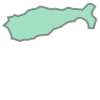

Buffered:


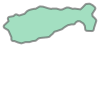

In [19]:
# the alpha value is adjusted to give the best curvature of the concave hull, so that the boundary is fitted to the outer stations
concave_hull, edge_points = alpha_shape(stations_with_stats.geometry, alpha=75)

print("Concave hull enclosing station coordinates:")
display(concave_hull)
print("Buffered:")

# The buffer value draws the boundary further away from the outer stations.
display(concave_hull.buffer(.005))

In [20]:
# Generate a tighter boundary using shapely's inbuilt function convex_hull
# convex_hull_polygon = point_collection.convex_hull
region_polys, region_pts = voronoi_regions_from_coords(coords, concave_hull.buffer(0.004))
#fig, ax = subplot_for_map()
#plot_voronoi_polys_with_points_in_area(ax, concave_hull.buffer(0.004), region_polys, coords, region_pts)
#plt.show()
vor_polys = [None]*len(region_polys)
for i in range(len(region_polys)):
    ind = region_pts[i][0]
#     display(region_polys[i])
    vor_polys[ind] = region_polys[i]

# Save polyogons and map to station indices
station_ids = stations_with_stats.index.to_list()
# df of stations with 2 columns, Id and geometry (voronoi polygons) 
vor_df = pd.DataFrame({'station_id':station_ids, 'geometry':vor_polys})

# create geodataframe, setting the projection
vor_gdf = gpd.GeoDataFrame(vor_df,crs=location_crs,geometry='geometry')
vor_gdf.set_index('station_id',inplace=True)
vor_gdf = vor_gdf.sort_index()
display(vor_gdf.head())

geometry
station_id                                                   
1           POLYGON ((-0.11279 51.53041, -0.11274 51.52936...
2           POLYGON ((-0.19757 51.50282, -0.20028 51.49965...
3           POLYGON ((-0.08416 51.51844, -0.08431 51.51852...
4           POLYGON ((-0.11962 51.52969, -0.12126 51.53236...
5           POLYGON ((-0.15601 51.49509, -0.15846 51.49310...

## Plotting with Folium

In [18]:
# Central location on map
# map_centre = [stations.latitude.mean(), stations.longitude.mean()]
map_centre = [stations_with_stats.geometry.y.mean(), stations_with_stats.geometry.x.mean()]
# Create a base map
london_map = folium.Map(
    location= map_centre, 
    tiles='cartodbpositron', 
    zoom_start=12
)

# Add ward polygons
folium.GeoJson(vor_gdf.geometry).add_to(london_map)

# Add station markers
for row in stations_with_stats.iterrows():
    row_values = row[1]
    location = [row_values.geometry.y,row_values.geometry.x]
    marker = folium.Circle(location=location, radius = 40, color='black', opacity=0,fill= 'black', fill_opacity = row_values['capacity']/64, popup = row_values['station_name'] + "\n"+"Capacity: "+ str(row_values['capacity']))
    marker.add_to(london_map)
    
london_map

In [19]:
# Merge the voronoi polygon geodataframe with the station location and summary stats geodataframe
# result = pd.merge(stations_with_stats, vor_gdf, on ='station_id')
stations_vor_stats = stations_with_stats.copy()
stations_vor_stats.geometry = vor_gdf.geometry
display(stations_vor_stats.head())

# write to geojson file for plotting as a layer
stations_vor_stats.to_file('voronoi.geojson', driver="GeoJSON") 

capacity   latitude  longitude  \
station_id                                   
1                 19  51.529163  -0.109970   
2                 37  51.499606  -0.197574   
3                 32  51.521283  -0.084605   
4                 23  51.530059  -0.120973   
5                 27  51.493130  -0.156876   

                                    station_name  \
station_id                                         
1                     River Street , Clerkenwell   
2                 Phillimore Gardens, Kensington   
3           Christopher Street, Liverpool Street   
4                St. Chad's Street, King's Cross   
5                  Sedding Street, Sloane Square   

                                                     geometry  journey_count  \
station_id                                                                     
1           POLYGON ((-0.11279 51.53041, -0.11274 51.52936...           8796   
2           POLYGON ((-0.19757 51.50282, -0.20028 51.49965...          15954   
3           POLYGON ((-0.08416 51.51844, -0.08431 51.51852...          19368   
4           POLYGON ((-0.11962 51.52969, -0.12126 51.53236...           9175   
5           POLYGON ((-0.15601 51.49509, -0.15846 51.49310...          22397   

            daily_journey_count  total_duration_hours  median_duration_mins  \
station_id                                                                    
1                         24.10           2161.887778                  11.0   
2                         43.71           5468.950000                  14.0   
3                         53.06           4584.153611                  12.0   
4                         25.14           3067.345833                  13.0   
5                         61.36           6635.390556                  13.0   

            journey_count_per_cap  
station_id                         
1                             1.3  
2                             1.2  
3                             1.7  
4                             1.1  
5                             2.3

## Plotting station statistics with geopandas geodataframe inbuilt methods

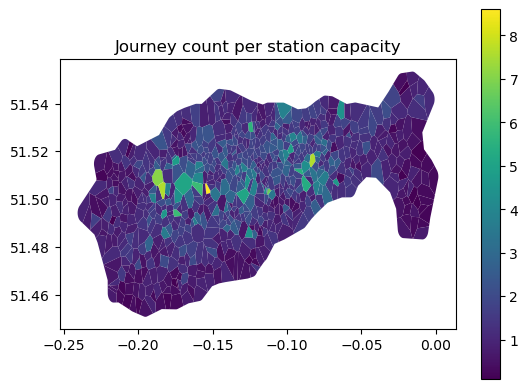

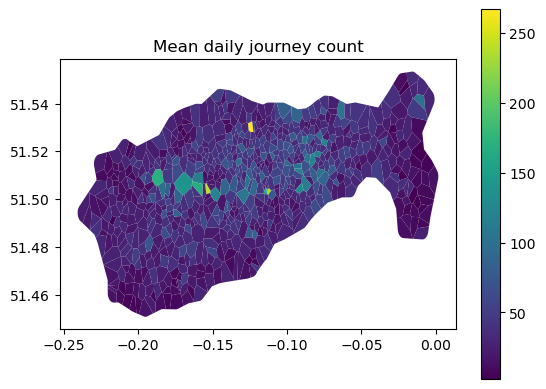

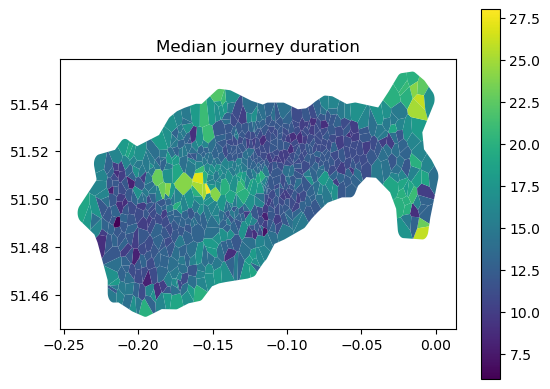

In [20]:
stations_vor_stats.plot(column='journey_count_per_cap', legend = True)
plt.title("Journey count per station capacity")
plt.show()
stations_vor_stats.plot(column='daily_journey_count', legend = True)
plt.title("Mean daily journey count")
plt.show()
stations_vor_stats.plot(column='median_duration_mins', legend = True)
plt.title("Median journey duration")
plt.show()

In [21]:
# Add station_id (currently index) as column
stations_with_stats['station_id'] = stations_with_stats.index.to_list()

## Plot interactive map

In [22]:
# Create a base map
london_map_v = folium.Map(
    location= map_centre, 
    tiles='cartodbpositron', 
    zoom_start=12.6
)

# Create a style function to display the bike scheme boundary (concave hull)
boundary_function =lambda x: {'fillColor': '#ffffff', 
                            'color':'blue', 
                            'fillOpacity': 0, 
                            'weight': 2}

# Add boundary to map
folium.GeoJson(concave_hull.buffer(0.004),style_function=boundary_function, name = 'Scheme boundary').add_to(london_map_v)

# Create a style function to display station regions (voronoi polygons)
region_function =lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0, 
                            'weight': 0.1}

# Add station regions to map
folium.GeoJson(vor_gdf.geometry,style_function=region_function, name = 'Voronoi regions').add_to(london_map_v)

# Create choropleth with journey count per station capacity
# The quantiles create a custom colour scale
custom_scale = (stations_vor_stats['journey_count_per_cap'].quantile((0,0.25,0.5,0.75,0.9,0.995,1))).tolist()
count_per_cap = folium.Choropleth(
            geo_data=r'voronoi.geojson',
            name = 'Journey Count / Station Capacity',
            data = stations_with_stats,
    # journey_count_per_cap
            columns=['station_id','journey_count_per_cap'],  #Here we tell folium to get the county fips and plot new_cases_7days metric for each county
            key_on='feature.properties.station_id', #Here we grab the geometries/county boundaries from the geojson file using the key 'coty_code' which is the same as county fips
            threshold_scale=custom_scale, #use the custom scale we created for legend
            fill_color = 'YlOrBr',
            nan_fill_color="White", #Use white color if there is no data available for the county
            fill_opacity=0.4,
            highlight=True,
            edgecolor='black',
            line_color = 'black',
            line_opacity=0.2,
            legend_name='Daily Journeys / Capacity', #title of the legend
)
count_per_cap.add_to(london_map_v)

# Create choropleth with median journey duration summary statistic
# Set a custom colour scale using quantiles
duration_scale = (stations_vor_stats['median_duration_mins'].quantile((0,0.25,0.5,0.75,0.9,0.995,1))).tolist()
# custom_scale = [min(stations_vor_stats['journey_count_per_cap']),100,200,300,400,500,max(stations_vor_stats['journey_count_per_cap'])]
journey_duration = folium.Choropleth(
            geo_data=r'voronoi.geojson',
            name = 'Median Journey Duration (mins)',
            data = stations_with_stats,
            columns=['station_id','median_duration_mins'],  #Here we tell folium to get the county fips and plot new_cases_7days metric for each county
            key_on='feature.properties.station_id', #Here we grab the geometries/county boundaries from the geojson file using the key 'coty_code' which is the same as county fips
            threshold_scale=duration_scale, #use the custom scale we created for legend
            fill_color = 'YlGnBu',
            nan_fill_color="White", #Use white color if there is no data available for the county
            fill_opacity=0.4,
            highlight=True,
            edgecolor='black',
            line_color = 'black',
            line_opacity=0.2,
            legend_name='Journey Duration', #title of the legend
)
journey_duration.add_to(london_map_v)

####################################################
yearly_trips_scale = (stations_vor_stats['journey_count'].quantile((0,0.66, 0.97, 0.99, 0.997,1))).tolist()
total_yearly_trips = folium.Choropleth(
            geo_data=r'voronoi.geojson',
            name = 'Total Yearly Trips',
            data = stations_with_stats,
    # yearly_trips_scale
            columns=['station_id','journey_count'],  #Here we tell folium to get the county fips and plot new_cases_7days metric for each county
            key_on='feature.properties.station_id', #Here we grab the geometries/county boundaries from the geojson file using the key 'coty_code' which is the same as county fips
            threshold_scale=yearly_trips_scale, #use the custom scale we created for legend
            fill_color = 'PiYG',
            nan_fill_color="Red", #Use red color if there is no data available for the county
            fill_opacity=0.5,
            highlight=True,
            edgecolor='black',
            line_color = 'black',
            line_opacity=0.2,
            legend_name='Total Yearly Trips', #title of the legend
)
total_yearly_trips.add_to(london_map_v)
#######################################################

# hover functionality
# the functions change the way station statistics are displayed on hover over station region
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.5, 
                                'weight': 0.1}
# Use the geojson file to display voronoi regions for each station
NIL = folium.features.GeoJson(
    r'voronoi.geojson',
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['station_name', 'capacity', 'daily_journey_count','journey_count_per_cap','median_duration_mins', "journey_count"],  # use fields from the json file
        aliases=['Station Name: ', 'Capacity: ','Daily Journeys: ',"Daily Journeys / Capacity: ",'Median Journey Duration: ', "Total Yearly Journeys: "],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
# add layer to map and keep in front
london_map_v.add_child(NIL)
london_map_v.keep_in_front(NIL)

# Add station markers - plot location of each station as circle, where opacity reflects station capacity
for row in stations_with_stats.iterrows():
    row_values = row[1]
    location = [row_values.geometry.y,row_values.geometry.x]
    marker = folium.Circle(location=location, radius = 40, color='black', opacity=0,fill= 'black', fill_opacity = row_values['capacity']/64, popup = row_values['station_name'] + "\n"+"Capacity: "+ str(row_values['capacity']))
    marker.add_to(london_map_v)

#Add layer control to the map
folium.LayerControl(collapsed=False).add_to(london_map_v)
london_map_v.save("interactive_stations_2017_map.html") #save to a file

# view map
london_map_v

In [23]:
min_max_table = pd.DataFrame(columns=['Station Name', 'Min', 'Max'])
column_names = ['journey_count','daily_journey_count','total_duration_hours','median_duration_mins','journey_count_per_cap']
# Iterate over each column
for col_name in column_names:
    # Find the minimum and maximum values in the column
    col_min = stations_with_stats[col_name].min()
    col_max = stations_with_stats[col_name].max()
    
    # Find the station name associated with the minimum and maximum values
    min_station = stations_with_stats.loc[stations_with_stats[col_name] == col_min, 'station_name'].iloc[0]
    max_station = stations_with_stats.loc[stations_with_stats[col_name] == col_max, 'station_name'].iloc[0]
    
    print(col_name)
    print("Minimum: ", col_min, min_station)
    print("Maximum: ", col_max, max_station)
    print("--------")


journey_count
Minimum:  878 Grant Road Central, Clapham Junction
Maximum:  97362 Belgrove Street , King's Cross
--------
daily_journey_count
Minimum:  2.41 Grant Road Central, Clapham Junction
Maximum:  266.75 Belgrove Street , King's Cross
--------
total_duration_hours
Minimum:  375.5236111111111 Grant Road Central, Clapham Junction
Maximum:  64525.470555555556 Hyde Park Corner, Hyde Park
--------
median_duration_mins
Minimum:  6.0 Barons Court Station, West Kensington
Maximum:  28.0 Hyde Park Corner, Hyde Park
--------
journey_count_per_cap
Minimum:  0.1 Castalia Square, Cubitt Town
Maximum:  8.6 Hyde Park Corner, Hyde Park
--------


## Results and conclusion

Toggling map chroropleth players shows that the greatest journey count per station capacity was 8.5 in the Hyde Park Corder station
<br>

This suggests that more stations could be added in these areas, or the capacity of existing stations could be increased.

The longest journeys were started from Park Lane, of 27 minuites on average.

This confirms that the number of stations or station capacity could be increased around Hyde Park.


## REFERENCES

- [Folium and Choropleth Map: From Zero to Pro](https://towardsdatascience.com/folium-and-choropleth-map-from-zero-to-pro-6127f9e68564)

- [Geovoronoi](https://pypi.org/project/geovoronoi/)
- [DRAWING BOUNDARIES IN PYTHON](https://thehumangeo.wordpress.com/2014/05/12/drawing-boundaries-in-python/)

- [How to create Voronoi regions with Geospatial data in Python](https://towardsdatascience.com/how-to-create-voronoi-regions-with-geospatial-data-in-python-adbb6c5f2134)
- [Create a Python Voronoi Diagram with GeoPandas and Geoplot](https://wellsr.com/python/python-voronoi-diagram-with-geopandas-and-geoplot/)
- [Computing the Voronoi diagram of a set of points](https://ipython-books.github.io/145-computing-the-voronoi-diagram-of-a-set-of-points/)